In [18]:
import numpy as np
import skimage
import skimage.io
import tensorflow.keras as keras
from path import Path
import tensorflow as tf
import math
import json

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.python.keras import backend as K
from keras.regularizers import l2

# image loader
from dtd_loader_color_patches import *

# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

NUM_CLASSES = 47
PATCH_SIZE = 128
channels = 3
batch_size = 32
nr_epochs = 15
weight_decay = 1e-6

In [19]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5433783548711339560
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16185408520156778964
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8452787460648552601
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15558698599
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13228312330408535975
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:07:00.0, compute capability: 6.0"
]


In [20]:
download_and_convert(tiled=True)

Directories for train, val and test already exist at target location
Remove the directories to convert the data again


In [28]:
# load label names
with open("classes.json", "r") as read_file:
    label_names = json.load(read_file)
    

In [29]:
def create_dataset(data_dir: str, nr_classes: int, patch_size: int, border_size: int, channels: int):
    path = Path(data_dir)
    image_files = list(path.glob('image*.png'))
    label_files = list(path.glob('label*.png'))
    
    # make sure they are in the same order
    image_files.sort()
    label_files.sort()
    image_files_array = np.asarray([str(p) for p in image_files])
    label_files_array = np.asarray([str(p) for p in label_files])
    dataset = tf.data.Dataset.from_tensor_slices((image_files_array, label_files_array))
    print(image_files_array)
    
    # shuffle the filenames, unfortunately, then we cannot cache them
    dataset = dataset.shuffle(buffer_size=10000)
    
    # read the images
    dataset = dataset.map(lambda image, label:_parse_function(image, label, channels))
    
    # Set the sizes of the input image, as keras needs to know them
    dataset = dataset.map(lambda x, y:(tf.reshape(x, shape=(patch_size, patch_size,channels)), y))
    
    # cut center of the label image in order to use valid filtering
    # in the network
    b = border_size
    
    if b != 0:
        dataset = dataset.map(lambda x, y:(x, y[b:-b, b:-b, :]))
        
    # reshape the labels to 1d array and do one-hot encoding
    dataset = dataset.map(lambda x,y:(x, tf.reshape(y, shape=[-1])))
    dataset = dataset.map(lambda x,y:(x, tf.one_hot(y, depth=nr_classes, dtype=tf.float32)))
    print(dataset.output_shapes)
    
    return dataset, image_files_array.size


In [30]:
def _parse_function(image_filename, label_filename, channels: int):
    """
    Parse image and label and return them. The image is divided by 255.0
    and returned as float, the label is returned as is in uint8 format.
    Args:
    image_filename: name of the image file
    label_filename: name of the label file
    channels: channels of the input image,
    Returns:
    tensors for the image and label read operations
    """
    image_string = tf.read_file(image_filename)
    image_decoded = tf.image.decode_png(image_string, channels=channels)
    image_decoded = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    
    # normalize image to zero mean
    image = tf.multiply(image_decoded, 2.0)
    image = tf.subtract(image, 1.0)
    label_string = tf.read_file(label_filename)
    label = tf.image.decode_png(label_string, dtype=tf.uint8, channels=1)
    
    return image, label

In [31]:
def fcn_simple_no_border(input_height:int, input_width:int, num_classes:int ) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 3)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=num_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=(input_height * input_width, num_classes)))
    
    
    return model, 0

In [42]:
def big_one(input_height:int, input_width:int, num_classes:int) -> (keras.Model, int):
    """
    Create a simple fcn model for semantic segmentation with 2 classes.
    Return both the model and the border size
    """
    model = keras.Sequential()
    border = 0;
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 3)))
    
    model.add(Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(UpSampling2D(size=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2), data_format='channels_last'))
    
    model.add(Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2), data_format='channels_last'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=num_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=((input_height-2*border) * (input_width-2*border), num_classes)))
    
    return model, border

In [43]:
model, border = big_one(PATCH_SIZE, PATCH_SIZE, num_classes = NUM_CLASSES) 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 256)     7168      
_________________________________________________________________
batch_normalization_v1_24 (B (None, 128, 128, 256)     1024      
_________________________________________________________________
activation_27 (Activation)   (None, 128, 128, 256)     0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
batch_normalization_v1_25 (B (None, 64, 64, 128)       512       
__________

In [44]:
#model = create_model(PATCH_SIZE, PATCH_SIZE, num_classes = NUM_CLASSES)
#model, border = fcn_simple_border(PATCH_SIZE, PATCH_SIZE, num_classes = NUM_CLASSES)
model, border = big_one(PATCH_SIZE, PATCH_SIZE, num_classes = NUM_CLASSES)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [45]:
dataset_train, nr_train_images = create_dataset("dtd_train_tiled", nr_classes=NUM_CLASSES, patch_size=PATCH_SIZE, border_size=border, channels=channels)
dataset_train = dataset_train.batch(batch_size).prefetch(buffer_size=1000).repeat()

dataset_test, nr_test_images = create_dataset("dtd_test_tiled", nr_classes=NUM_CLASSES, patch_size=PATCH_SIZE, border_size=border, channels=channels)
dataset_test = dataset_test.batch(batch_size).prefetch(buffer_size=1000).repeat()

dataset_val, nr_val_images = create_dataset("dtd_val_tiled", nr_classes=NUM_CLASSES, patch_size=PATCH_SIZE, border_size=border, channels=channels)
dataset_val = dataset_val.batch(batch_size).prefetch(buffer_size=1000).repeat()

train_steps_per_epoch = math.floor(nr_train_images / batch_size)
test_steps_per_epoch = math.floor(nr_test_images / batch_size)
val_steps_per_epoch = math.floor(nr_val_images / batch_size)

['dtd_train_tiled/image_00000.png' 'dtd_train_tiled/image_00001.png'
 'dtd_train_tiled/image_00002.png' ... 'dtd_train_tiled/image_20150.png'
 'dtd_train_tiled/image_20151.png' 'dtd_train_tiled/image_20152.png']
(TensorShape([Dimension(128), Dimension(128), Dimension(3)]), TensorShape([Dimension(None), Dimension(47)]))
['dtd_test_tiled/image_00000.png' 'dtd_test_tiled/image_00001.png'
 'dtd_test_tiled/image_00002.png' ... 'dtd_test_tiled/image_19446.png'
 'dtd_test_tiled/image_19447.png' 'dtd_test_tiled/image_19448.png']
(TensorShape([Dimension(128), Dimension(128), Dimension(3)]), TensorShape([Dimension(None), Dimension(47)]))
['dtd_val_tiled/image_00000.png' 'dtd_val_tiled/image_00001.png'
 'dtd_val_tiled/image_00002.png' ... 'dtd_val_tiled/image_20002.png'
 'dtd_val_tiled/image_20003.png' 'dtd_val_tiled/image_20004.png']
(TensorShape([Dimension(128), Dimension(128), Dimension(3)]), TensorShape([Dimension(None), Dimension(47)]))


In [46]:
model.fit(dataset_train,
          validation_data=dataset_val,
          validation_steps=val_steps_per_epoch,
          steps_per_epoch=train_steps_per_epoch,
          epochs=nr_epochs)

Epoch 1/15
629/629 [==============================] - 147s 234ms/step - loss: 3.5378 - acc: 0.0855 - val_loss: 3.7035 - val_acc: 0.0893
Epoch 2/15
629/629 [==============================] - 145s 230ms/step - loss: 3.2512 - acc: 0.1492 - val_loss: 3.4445 - val_acc: 0.1262
Epoch 3/15
629/629 [==============================] - 144s 229ms/step - loss: 3.0309 - acc: 0.1980 - val_loss: 3.4019 - val_acc: 0.1540
Epoch 4/15
629/629 [==============================] - 145s 230ms/step - loss: 2.8453 - acc: 0.2432 - val_loss: 3.4109 - val_acc: 0.1669
Epoch 5/15
629/629 [==============================] - 145s 230ms/step - loss: 2.6877 - acc: 0.2791 - val_loss: 3.4203 - val_acc: 0.1597
Epoch 6/15
629/629 [==============================] - 145s 231ms/step - loss: 2.5314 - acc: 0.3148 - val_loss: 3.2978 - val_acc: 0.1992
Epoch 7/15
629/629 [==============================] - 146s 232ms/step - loss: 2.4122 - acc: 0.3438 - val_loss: 3.2684 - val_acc: 0.2123
Epoch 8/15
629/629 [============================

In [67]:
path = Path("dtd_test_tiled")
image_files = list(path.glob('image*.png'))
label_files = list(path.glob('label*.png'))

# make sure they are in the same order
image_files.sort()
label_files.sort()
image_files_array = np.asarray([str(p) for p in image_files])
label_files_array = np.asarray([str(p) for p in label_files])


dtd_test_tiled/label_00001.png
Label is :4 which is bubbly
(1, 128, 128, 3)
(1, 16384, 47)
[[35 35  4 ...  4 27 27]
 [35 35  4 ...  4 27 27]
 [35 35  4 ...  4  4  4]
 ...
 [ 4  4  4 ... 38 38 38]
 [ 4  4  4 ... 38 38 38]
 [ 4  4  4 ... 38 38 38]]


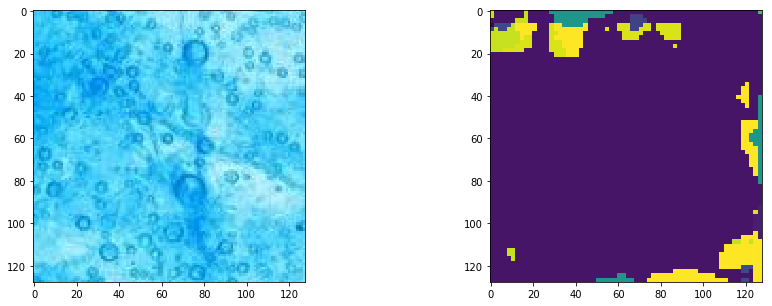

### Attention displayed label might be wrong. If the centroid of a region lays not inside the region (e.g. not a convex region) then the wrong label will be pickt

[[35 35  4 ...  4 27 27]
 [35 35  4 ...  4 27 27]
 [35 35  4 ...  4  4  4]
 ...
 [ 4  4  4 ... 38 38 38]
 [ 4  4  4 ... 38 38 38]
 [ 4  4  4 ... 38 38 38]]


Text(0.5, 1.0, 'Label should be bubbly')

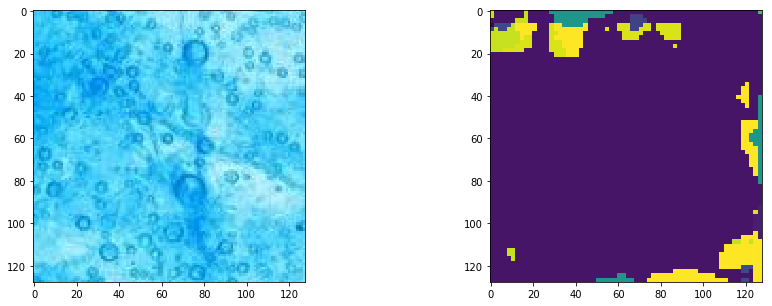

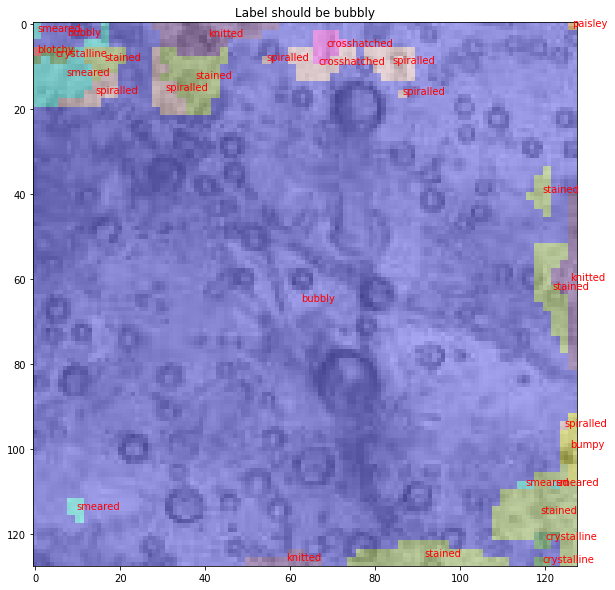

In [126]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,5))

image_nr = 1 # test data image nr. 300 is a perfect match
im = skimage.io.imread(image_files_array[image_nr])/127.5-1
lab = skimage.io.imread(label_files_array[image_nr])
#print(label_files_array[image_nr])
#print("Label is :{} which is {}".format(np.max(lab), label_names[str(np.max(lab))]))
#print(lab.shape)
ax0.imshow((im+1)/2, vmax=1,vmin=0)
#print(im)

im2=np.expand_dims(im, axis=0)
#print(im2.shape)
prediction = model.predict(im2)
#print(prediction.shape)
test = np.reshape(prediction, (128,128,47))
argmax_value = np.argmax(test, axis=2)
ax1.imshow(argmax_value)
print(argmax_value)

independent_label=skimage.measure.label(argmax_value)
regions = skimage.measure.regionprops(independent_label)
large_regions = [r for r in regions if r.area>0]
centroid = [r.centroid for r in large_regions]
labels = [r.label for r in large_regions]
fig, ax = plt.subplots(figsize=(25,10))
ax.imshow(skimage.color.label2rgb(argmax_value, (im+1)/2))
#ax.imshow((im+1)/2, vmax=1,vmin=0)
for (r,label) in zip(centroid,labels):
    ax.annotate(label_names[str(argmax_value[int(r[0]),int(r[1])])], xy=(r[1],r[0]), fontsize=10, color='red')
ax.set_title("Label should be {}".format(label_names[str(np.max(lab))]))

[[13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 ...
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]]


Text(0.5, 1.0, 'Label should be flecked')

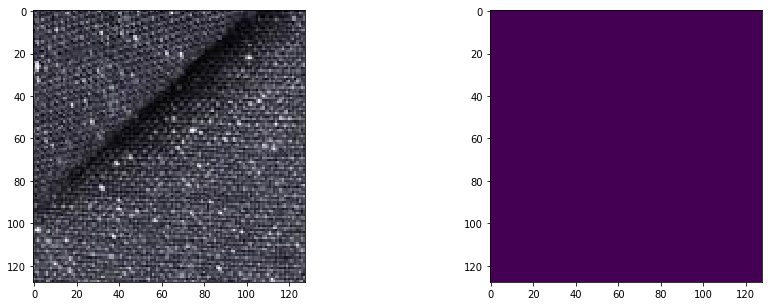

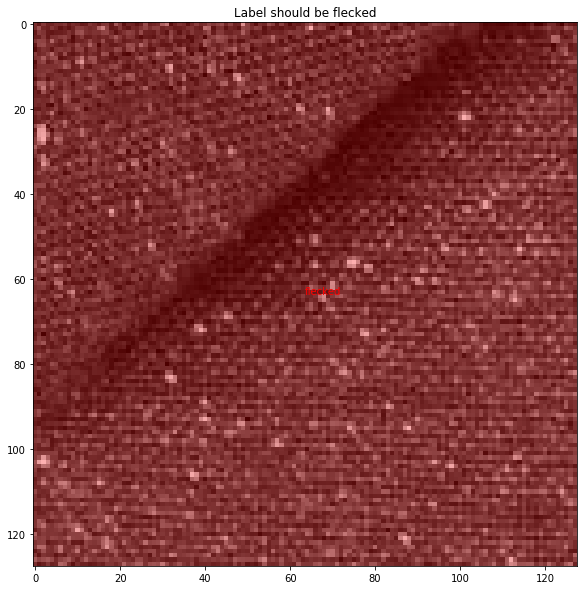

In [127]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,5))

image_nr = 300 
im = skimage.io.imread(image_files_array[image_nr])/127.5-1
lab = skimage.io.imread(label_files_array[image_nr])
#print(label_files_array[image_nr])
#print("Label is :{} which is {}".format(np.max(lab), label_names[str(np.max(lab))]))
#print(lab.shape)
ax0.imshow((im+1)/2, vmax=1,vmin=0)
#print(im)

im2=np.expand_dims(im, axis=0)
#print(im2.shape)
prediction = model.predict(im2)
#print(prediction.shape)
test = np.reshape(prediction, (128,128,47))
argmax_value = np.argmax(test, axis=2)
ax1.imshow(argmax_value)
print(argmax_value)

independent_label=skimage.measure.label(argmax_value)
regions = skimage.measure.regionprops(independent_label)
large_regions = [r for r in regions if r.area>0]
centroid = [r.centroid for r in large_regions]
labels = [r.label for r in large_regions]
fig, ax = plt.subplots(figsize=(25,10))
ax.imshow(skimage.color.label2rgb(argmax_value, (im+1)/2))
#ax.imshow((im+1)/2, vmax=1,vmin=0)
for (r,label) in zip(centroid,labels):
    ax.annotate(label_names[str(argmax_value[int(r[0]),int(r[1])])], xy=(r[1],r[0]), fontsize=10, color='red')
ax.set_title("Label should be {}".format(label_names[str(np.max(lab))]))